In [9]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

In [3]:
annot_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/annotations.csv')
annot_df

,filename,white,rose,yellow,tulip,red,chrysanthemum
0,white_rose_116.jpg,1,1,0,0,0,0
1,white_rose_96.jpg,1,1,0,0,0,0
2,white_rose_102.jpg,1,1,0,0,0,0
3,white_rose_69.jpg,1,1,0,0,0,0
4,white_rose_55.jpg,1,1,0,0,0,0
...,...,...,...,...,...,...,...
1585,red_chrysanthemum_76.jpg,0,0,0,0,1,1
1586,red_chrysanthemum_62.jpg,0,0,0,0,1,1
1587,red_chrysanthemum_100.jpg,0,0,0,0,1,1
1588,red_chrysanthemum_128.jpg,0,0,0,0,1,1


# Custom Dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annot_df, classes, transforms):
        super().__init__()
        self.root_path = root_path
        self.classes = classes
        self.transforms = transforms
        self.annot_df = annot_df
        self.data = annot_df['filename']

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.data[idx])
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        labels = []
        for i in range(1, 7):
            labels.append(self.annot_df.iloc[idx, i])
        labels = torch.tensor(labels, dtype=torch.float)
        
        return img, labels

In [5]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/images'
annot_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/annotations.csv')
classes = ['white', 'rose', 'yellow', 'tulip', 'red', 'chrysanthemum']

total_dataset = CustomDataset(root_path, annot_df, classes, transforms)

In [6]:
total_dataset[0]

(tensor([[[0.7725, 0.7725, 0.8000,  ..., 0.8078, 0.8078, 0.8078],
          [0.7922, 0.7765, 0.7765,  ..., 0.8039, 0.8078, 0.8078],
          [0.7725, 0.7961, 0.7686,  ..., 0.7922, 0.8039, 0.8078],
          ...,
          [0.6980, 0.6980, 0.7020,  ..., 0.8078, 0.8078, 0.8078],
          [0.6980, 0.6980, 0.7059,  ..., 0.8078, 0.8078, 0.8078],
          [0.6980, 0.6980, 0.6980,  ..., 0.8078, 0.8078, 0.8078]],
 
         [[0.8078, 0.8078, 0.7922,  ..., 0.7882, 0.7882, 0.7882],
          [0.7961, 0.8039, 0.8039,  ..., 0.7922, 0.7961, 0.7961],
          [0.8078, 0.7961, 0.8118,  ..., 0.7804, 0.7922, 0.7961],
          ...,
          [0.6784, 0.6784, 0.6824,  ..., 0.7882, 0.7882, 0.7882],
          [0.6784, 0.6784, 0.6863,  ..., 0.7882, 0.7882, 0.7882],
          [0.6784, 0.6784, 0.6784,  ..., 0.7882, 0.7882, 0.7882]],
 
         [[0.9137, 0.9137, 0.9137,  ..., 0.9020, 0.9020, 0.9020],
          [0.9137, 0.9137, 0.9137,  ..., 0.8627, 0.8667, 0.8667],
          [0.9137, 0.9137, 0.9137,  ...,

In [7]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# train, eval

In [10]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evalutation(model, valid_dataloader, threshold, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []
    
    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, threshold, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evalutation(model, valid_dataloader, threshold, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [11]:
model = timm.create_model(
    'resnet18',
    num_classes=len(classes),
    pretrained=True
)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [13]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.layer4.parameters():
    parameter.requires_grad = True

for parameter in model.fc.parameters():
    parameter.requires_grad = True

# 학습

In [14]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, 0.5, criterion, optimizer, 10)

  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4793302915990353, Train F1: 0.5173163891307642, Valid Loss: 0.23756156861782074, Valid F1: 0.8884161862100991


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.19654766023159026, Train F1: 0.9055718095744894, Valid Loss: 0.13490757197141648, Valid F1: 0.9422334693266065


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.08981142276898027, Train F1: 0.9603477014006038, Valid Loss: 0.11898797899484634, Valid F1: 0.9459453788247386


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.044807609217241404, Train F1: 0.9843686879515978, Valid Loss: 0.10325494855642318, Valid F1: 0.9475911555807581


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.027142529212869703, Train F1: 0.9940179375141858, Valid Loss: 0.09581409692764283, Valid F1: 0.9502433679010832


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.019393325480632485, Train F1: 0.9936999325201509, Valid Loss: 0.10649191290140152, Valid F1: 0.9499480178975458


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.013526533113326878, Train F1: 0.9961838464954882, Valid Loss: 0.11108216792345046, Valid F1: 0.9405010656050067


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.009752769506303594, Train F1: 0.9988330452759371, Valid Loss: 0.11022861748933792, Valid F1: 0.9456628648835793


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.006489883665926755, Train F1: 0.9988020235613524, Valid Loss: 0.11311202496290207, Valid F1: 0.9506520957538364


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.006079494752339087, Train F1: 0.9988244083884928, Valid Loss: 0.11346682980656624, Valid F1: 0.953569545308259


# test

In [15]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='macro'))

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0.9382437087684766


/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


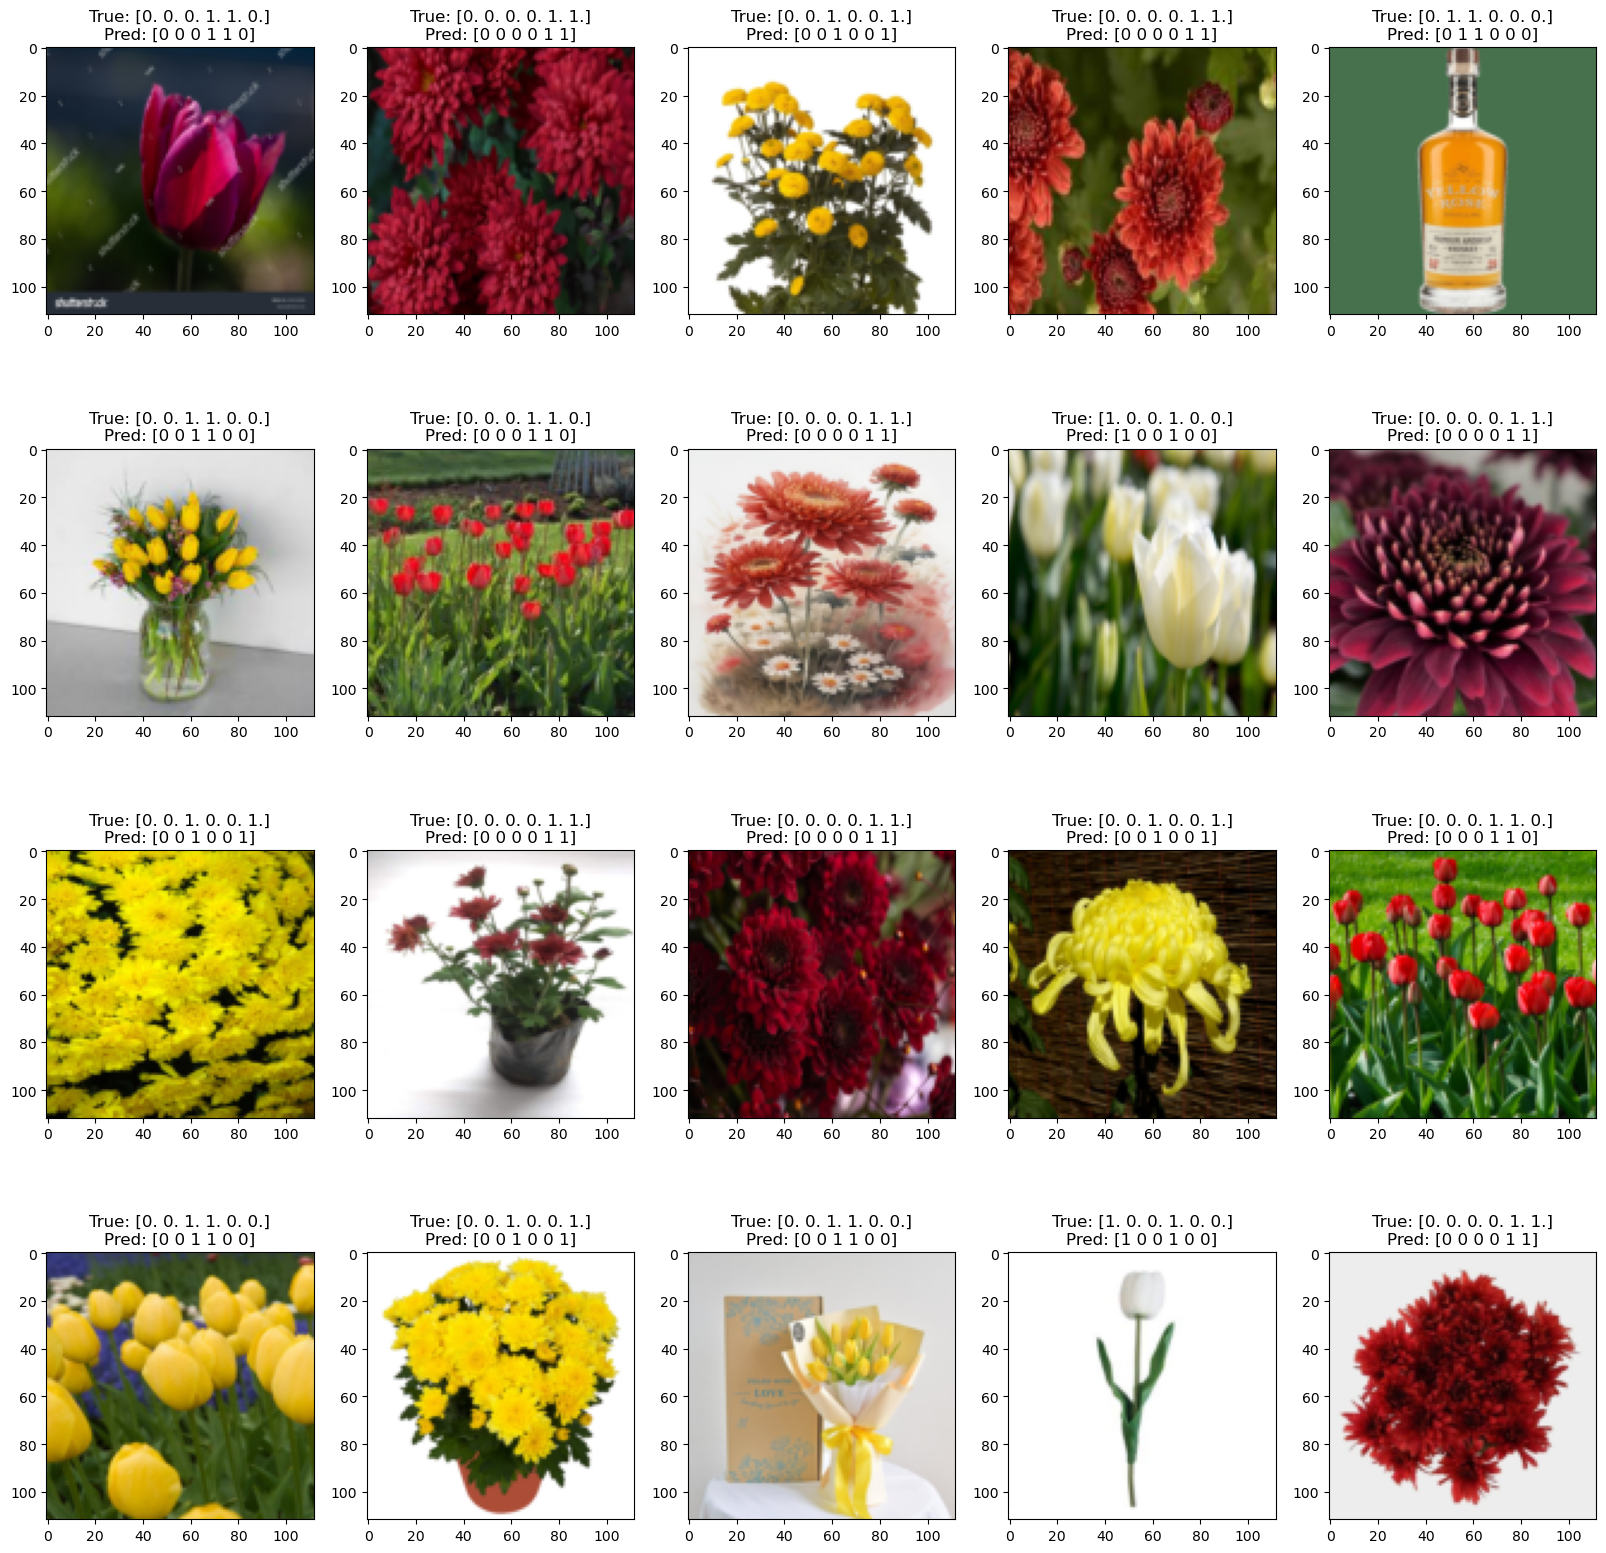

In [21]:
plt.figure(figsize=(20, 20))

for i in range(20):
    plt.subplot(4, 5, i+1)
    img = test_dataset[i][0]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')